<a href="https://colab.research.google.com/github/swlee123/Food-Vision-Computer-Vision/blob/main/Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1 :Food Vision Big

See the template of this notebook on Github : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

## Check GPU

Google Colab offers free GPUs ,however , not all of them are compatible with [mixed precision](https://www.tensorflow.org/guide/mixed_precision) training.

Google Colab offers:
* k80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from Colab) of if we're using our own hardware, our GPU needs a score of 7.0+  https://developer.nvidia.com/cuda-gpus#compute

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-04317e7e-0286-0605-e2c2-226b3ee0e807)
GPU 1: Tesla T4 (UUID: GPU-a9c3b884-5853-9927-3e7c-a4bcd40433bc)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.
Rather than rewrite all of there, we can import a script and load them in from there.
The script we've got available can be found on Github https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Dowload helper function scripts

! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-29 15:02:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-29 15:02:13 (48.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import series of helper functions for the notebook

from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

## Use Tensorflow Dataset to download data

If you want to get an overview on tensorflow dataset read https://www.tensorflow.org/datasets/overview

In [5]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [6]:
# list all available datasets
dataset_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in dataset_list) # is our target dataset in the dataset_list?

2022-12-29 15:02:24.916284: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


In [7]:
# Load in the data (takes 5-6 mins in Google Colab)
(train_data,test_data),ds_info = tfds.load(name="food101",
                                   split=["train","validation"],
                                   shuffle_files =False,
                                   as_supervised = True, # data gets returned in tuple format (data,label)
                                   with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling food101-train.tfrecord...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling food101-validation.tfrecord...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


2022-12-29 15:11:05.776152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:11:05.778475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:11:06.111883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:11:06.112856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:11:06.113647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Exploring our dataset

We need to find:
* Class names
* The shape of our input data (image tensor)
* The datatype of our input data
* What the labels looks like (one-hot encoded or label encoded)
* Do the labels match up with the class names?

In [8]:
# Features of Food101 from TFDS
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get the class names 
class_names = ds_info.features["label"].names

In [10]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of train data
train_one_sample = train_data.take(1) # (image_tensor,label)

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# output info of our training sample

for image,label in train_one_sample:
  print(f"""
  Image shape : {image.shape},
  Image datatype : {image.dtype},
  Target class from Food101 (tensor form) : {label}
  Class name (str form) : {class_names[label.numpy()]}

  """)

2022-12-29 15:11:12.957796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



  Image shape : (512, 512, 3),
  Image datatype : <dtype: 'uint8'>,
  Target class from Food101 (tensor form) : 56
  Class name (str form) : huevos_rancheros

  


In [14]:
# what image tensor look like ?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [15]:
import tensorflow as tf

# max and min in image tensor (usually 0-255)
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from tensorflow dataset



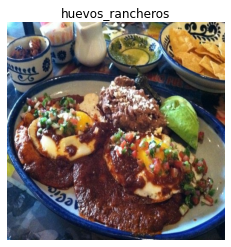

In [16]:
# plot an image tensor

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(tf.cast(image,dtype=tf.float32)/255.)
plt.title(f"{class_names[label.numpy()]}")
plt.axis(False)
plt.show()


In [17]:
# make a function to random a image from the dataset 

def random_image():
  # Take one sample of train data
  train_one_sample = train_data.take(1) # (image_tensor,label)
  # output info of our training sample

  for image,label in train_one_sample:
    print(f"""
    Image shape : {image.shape},
    Image datatype : {image.dtype},
    Target class from Food101 (tensor form) : {label}
    Class name (str form) : {class_names[label.numpy()]}
    """)
  # plot an image tensor

  import matplotlib.pyplot as plt

  plt.figure()
  plt.imshow(tf.cast(image,dtype=tf.float32)/255.)
  plt.title(f"{class_names[label.numpy()]}")
  plt.axis(False)
  plt.show()





    Image shape : (512, 512, 3),
    Image datatype : <dtype: 'uint8'>,
    Target class from Food101 (tensor form) : 56
    Class name (str form) : huevos_rancheros
    


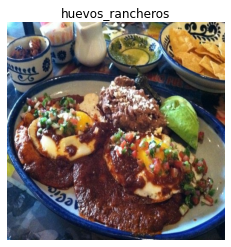

In [18]:
random_image() # you can rerun this cell multiple times to look at our data 

## Create preprocessing functions for our data

Neural Network perform best when data is in a certain way(e.g. batched, normalized, etc)

However, not all data (including data from Tensorflow Datasets) comes like this.

So in order to get it ready for a neural netowrk, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:

* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled( the pixel values are between 0 and 255)

What we know models like:

* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tacle with a preprocessing function

Since we're going to be using EfficientNetBX pretrained model from tf.keras.applications we dont need to rescale our data (these architectures have rescaling built-in)

This means our functions needs to:

 1. Reshape our images to same size
 2. Convert the dtype of image tensors from `unit8` to `floaat32`

In [19]:
# Make a function for preprocessing images 
def preprocess_img(image,label,img_shape=224):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes image to [img_shape,img_shape,color channels]
  """

  image = tf.image.resize(image,[img_shape,img_shape])
  # not required to scale it as EfficeintNet has a rescaling layer to do it
  image = tf.cast(image,dtype=tf.float32)
  return image,label # return tuple of (float32_img,label)


In [20]:
# preprocess a single sample image and check it's output

preprocessed_img = preprocess_img(image,label)[0]

print(f"Before preprocessing : \n {image[:2]}...,\n Shape :{image.shape},\n Datatype :{image.dtype}")
print(f"After preprocessing : \n {preprocessed_img[:2]}...,\n Shape :{preprocessed_img.shape},\n Datatype :{preprocessed_img.dtype}")

Before preprocessing : 
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
 Shape :(512, 512, 3),
 Datatype :<dtype: 'uint8'>
After preprocessing : 
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
 Shape :(224, 224, 3),
 Datatype :<dtype: 'float32'>


## Batch and prepare dataset

Previously we use tf.image_from_directory().
Now we're going to make our data input pipeline going throught very fast , we're using examples from the guide https://www.tensorflow.org/guide/data_performance




In [21]:
train_data

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [22]:
# map preprocessing function to training (and parallelize)

train_data_processed = train_data.map(map_func = preprocess_img,num_parallel_calls=tf.data.AUTOTUNE  )# utillize the cpu/gpu power

# shuffle train_data and turn it into batches and prefetch it (loaad faster)

train_data_processed = train_data_processed.shuffle(buffer_size = 1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# .shuffle buffer size shuffle 1000 imgs 1 time
# tf.data.AUTOTUNE is to find all computing power as possible to utillize it 


# map preprocessing functions to test data
test_data_processed = test_data.map(map_func = preprocess_img,num_parallel_calls=tf.data.AUTOTUNE ).batch(32).prefetch(tf.data.AUTOTUNE)

# all of this method are to use to speed up our pipeline in our model

In [23]:
train_data_processed,test_data_processed

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [24]:
train_data,test_data

(<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>)

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our models trains:

* Tensorboard callback to log training results
* ModelCheckPoint callback to save our model's progress after feature extraction


In [25]:
# create tensorboard callback (helper function .py)
from helper_functions import create_tensorboard_callback

# create model checkpoint callbacks to save our model's a progress during training
checkpoint_path = "model_checkpoint/ck.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weight_only=True,
                                                      verbose=0) 


In [26]:
tf.__version__ # maybe will have bug occur for cells afterward

'2.6.4'

## Setup mixed precision training

For deeper understanding for mixed precision training
https://www.tensorflow.org/guide/mixed_precision

Mixed precision utillize the combination of float32 and floaat16 data types to speed up model performance

In [27]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision


2022-12-29 15:11:20.031423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:11:20.034242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [28]:
mixed_precision.global_policy() # check policy we are using

<Policy "mixed_float16">

## build feature extraction model


You might found some bugs when running code below using tensorflow 2.5++ ,
the solution found is to downgraded the tensorflow version to <2.5 by running code below (run if bug is encountered)

In [29]:
# Downgrade Tensorflow Version (run this in Google Colab) 
# !pip install tensorflow==2.4.1

In [30]:
import tensorflow as tf
tf.__version__


'2.6.4'

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model

input = layers.Input(shape=input_shape,name="input_layer")
# efficient net got built-in rescaling layer (optional can run code below)
# x = preprocessing.Rescale(1/255.) (x)

x = base_model(input,training=False) # put it in inference (not training ) mode

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(len(class_names))(x)

output = layers.Activation("softmax",dtype=tf.float32,name="softmax_activation")(x)

model = tf.keras.Model(input,output)


# compile the model

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # one-hot label - categorical
                                                            # more than one label = sparse
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

16719872/16705208 [==============================] - 0s 0us/step


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_activation (Activati (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

I am turning off mixed percision training for the sake of training time, it i use mixed precision, it cost like 100++ hours to train , but i surfed the discord someone came out with a solution to close the mixed precision

In [33]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("float32") # set global data policy back to float32 policy


In [34]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model

input = layers.Input(shape=input_shape,name="input_layer")
# efficient net got built-in rescaling layer (optional can run code below)
# x = preprocessing.Rescale(1/255.) (x)

x = base_model(input,training=False) # put it in inference (not training ) mode

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(len(class_names))(x)

output = layers.Activation("softmax",name="softmax_activation")(x)

model = tf.keras.Model(input,output)


# compile the model

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), # one-hot label - categorical
                                                            # more than one label = sparse
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [35]:
# check if model is using mixed precision training layer by layer

for layer in model.layers:
  print(f"dtype policy: {model.dtype_policy}")


dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">


In [36]:
# check info of layers in efficientnetb0 

for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype_policy,layer.dtype)

print(f"Number of layers {len(base_model.layers)}")

input_2 False <Policy "float32"> float32
rescaling_1 False <Policy "float32"> float32
normalization_1 False <Policy "float32"> float32
stem_conv_pad False <Policy "float32"> float32
stem_conv False <Policy "float32"> float32
stem_bn False <Policy "float32"> float32
stem_activation False <Policy "float32"> float32
block1a_dwconv False <Policy "float32"> float32
block1a_bn False <Policy "float32"> float32
block1a_activation False <Policy "float32"> float32
block1a_se_squeeze False <Policy "float32"> float32
block1a_se_reshape False <Policy "float32"> float32
block1a_se_reduce False <Policy "float32"> float32
block1a_se_expand False <Policy "float32"> float32
block1a_se_excite False <Policy "float32"> float32
block1a_project_conv False <Policy "float32"> float32
block1a_project_bn False <Policy "float32"> float32
block2a_expand_conv False <Policy "float32"> float32
block2a_expand_bn False <Policy "float32"> float32
block2a_expand_activation False <Policy "float32"> float32
Number of layer

In [37]:
# check if model is not using mixed precision training layer by layer

for layer in model.layers:
  print(f"dtype policy: {model.dtype_policy}")


dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">


## Fit the feature extraction model

If our goal it to fine-tune a pretrained model, the general order of doing things is to:

1. Build a feature extraction model (train a couple output layer with base layers frozen
2. Fine-tune some of the frozen layers

## Real challenge starts here ...

In [38]:
# another solution from comment section in udemy

# !pip install tensorflow==2.11.0

In [39]:
# fit the model

history_1_feature_extraction = model.fit(train_data_processed,
                              epochs=3,
                              steps_per_epoch=len(train_data_processed),
                              validation_data=test_data_processed,
                              validation_steps = int(len(test_data_processed)*0.10),
                              callbacks=[create_tensorboard_callback("training_log","efficient_net_ex1"),model_checkpoint])

2022-12-29 15:11:25.750119: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-29 15:11:25.750162: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-29 15:11:25.753350: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs


Saving TensorBoard log files to: training_log/efficient_net_ex1/20221229-151125
Epoch 1/3


2022-12-29 15:11:26.126645: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-29 15:11:26.126903: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-29 15:11:33.253723: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-12-29 15:11:33.326127: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-12-29 15:11:35.049113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/2368 [..............................] - ETA: 12:12:48 - loss: 4.6544 - accuracy: 0.0000e+00

2022-12-29 15:11:45.145015: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-29 15:11:45.145074: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2368 [..............................] - ETA: 42:21 - loss: 4.6253 - accuracy: 0.0000e+00   

2022-12-29 15:11:46.063785: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-29 15:11:46.064741: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-29 15:11:46.068107: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2022-12-29 15:11:46.235828: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 509 callback api events and 506 activity events. 
2022-12-29 15:11:46.256527: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   3/2368 [..............................] - ETA: 29:22 - loss: 4.6558 - accuracy: 0.0000e+00

2022-12-29 15:11:46.310948: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_log/efficient_net_ex1/20221229-151125/train/plugins/profile/2022_12_29_15_11_46

2022-12-29 15:11:46.325811: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_log/efficient_net_ex1/20221229-151125/train/plugins/profile/2022_12_29_15_11_46/b483afa6f6e1.trace.json.gz
2022-12-29 15:11:46.391521: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_log/efficient_net_ex1/20221229-151125/train/plugins/profile/2022_12_29_15_11_46

2022-12-29 15:11:46.397961: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to training_log/efficient_net_ex1/20221229-151125/train/plugins/profile/2022_12_29_15_11_46/b483afa6f6e1.memory_profile.json.gz
2022-12-29 15:11:46.399366: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] 

   6/2368 [..............................] - ETA: 13:25 - loss: 4.6427 - accuracy: 0.0208  

2022-12-29 15:11:46.543844: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


2368/2368 [==============================] - 205s 79ms/step - loss: 1.8216 - accuracy: 0.5576 - val_loss: 1.2369 - val_accuracy: 0.6741


2022-12-29 15:15:04.033709: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
2368/2368 [==============================] - 194s 81ms/step - loss: 1.2956 - accuracy: 0.6666 - val_loss: 1.1358 - val_accuracy: 0.6958


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/3
2368/2368 [==============================] - 191s 79ms/step - loss: 1.1446 - accuracy: 0.7023 - val_loss: 1.0918 - val_accuracy: 0.7021


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [40]:
# evaluate on whole test data set

result_feature_extract = model.evaluate(test_data_processed)
result_feature_extract

790/790 [==============================] - 58s 73ms/step - loss: 1.0966 - accuracy: 0.7045


[1.0965865850448608, 0.7044752240180969]

## Prepraring model's layers for fine-tuning

In [41]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)

for layer in model.layers[1].layers:
    layer.trainable = True
    print(layer.name,layer.trainable)

input_2 True
rescaling_1 True
normalization_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True


In [42]:
# Check to see what dtype_policy of the layers in your loaded model are

for layer in model.layers:
  print(f"dtype policy: {model.dtype_policy}")


dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">
dtype policy: <Policy "float32">


In [43]:
# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_path_2 = "model_checkpoint/ck_2.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_2,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weight_only=True,
                                                      verbose=0) 

# early stopping callbacks
# this callbacks will stop the training when there is no improvement
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,min_delta=0.005)



In [44]:

# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.0001),
    metrics = ["accuracy"]
)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:

# Start to fine-tune (all layers)
# Use 15 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

history_2 = model.fit(train_data_processed,
         epochs = 15,
         verbose="auto",
         validation_data = test_data_processed,
         validation_steps=int(len(test_data_processed)*0.15),
         callbacks=[model_checkpoint,es_callback,create_tensorboard_callback("training_log","efficient_net_ex2")],
         steps_per_epoch=len(train_data_processed),
         initial_epoch = history_1_feature_extraction.epoch[-1]
         )


2022-12-29 15:25:58.949094: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-29 15:25:58.949142: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-29 15:25:59.730392: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-29 15:25:59.730611: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: training_log/efficient_net_ex2/20221229-152558
Epoch 3/15
   1/2368 [..............................] - ETA: 5:53:14 - loss: 0.9207 - accuracy: 0.8125

2022-12-29 15:26:09.286933: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-29 15:26:09.286981: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2368 [..............................] - ETA: 34:46 - loss: 0.9470 - accuracy: 0.7812  

2022-12-29 15:26:10.353032: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-29 15:26:10.354650: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


   3/2368 [..............................] - ETA: 32:47 - loss: 0.9868 - accuracy: 0.7708

2022-12-29 15:26:10.582097: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 509 callback api events and 506 activity events. 
2022-12-29 15:26:10.602374: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-29 15:26:10.626246: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_log/efficient_net_ex2/20221229-152558/train/plugins/profile/2022_12_29_15_26_10

2022-12-29 15:26:10.640124: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_log/efficient_net_ex2/20221229-152558/train/plugins/profile/2022_12_29_15_26_10/b483afa6f6e1.trace.json.gz
2022-12-29 15:26:10.684076: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_log/efficient_net_ex2/20221229-152558/train/plugins/profile/2022_12_29_15_26_10

2022-12-29 15:26:10.691260: I tensorflow/core/profiler/rpc/client/save_profile

2368/2368 [==============================] - 211s 85ms/step - loss: 0.9743 - accuracy: 0.7502 - val_loss: 1.0522 - val_accuracy: 0.7209


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
2368/2368 [==============================] - 195s 81ms/step - loss: 0.9568 - accuracy: 0.7566 - val_loss: 1.0474 - val_accuracy: 0.7222


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
2368/2368 [==============================] - 194s 81ms/step - loss: 0.9455 - accuracy: 0.7602 - val_loss: 1.0450 - val_accuracy: 0.7214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
2368/2368 [==============================] - 197s 82ms/step - loss: 0.9357 - accuracy: 0.7626 - val_loss: 1.0432 - val_accuracy: 0.7206


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
2368/2368 [==============================] - 193s 80ms/step - loss: 0.9268 - accuracy: 0.7648 - val_loss: 1.0409 - val_accuracy: 0.7225


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
2368/2368 [==============================] - 194s 81ms/step - loss: 0.9183 - accuracy: 0.7669 - val_loss: 1.0396 - val_accuracy: 0.7211


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
2368/2368 [==============================] - 202s 84ms/step - loss: 0.9101 - accuracy: 0.7695 - val_loss: 1.0378 - val_accuracy: 0.7209


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
2368/2368 [==============================] - 203s 84ms/step - loss: 0.9023 - accuracy: 0.7715 - val_loss: 1.0359 - val_accuracy: 0.7214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
2368/2368 [==============================] - 206s 85ms/step - loss: 0.8948 - accuracy: 0.7735 - val_loss: 1.0349 - val_accuracy: 0.7222


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [46]:
# evaluate the trained model

fine_tuned_result = model.evaluate(test_data_processed)
fine_tuned_result

790/790 [==============================] - 59s 74ms/step - loss: 1.0380 - accuracy: 0.7202


[1.0379881858825684, 0.7202376127243042]

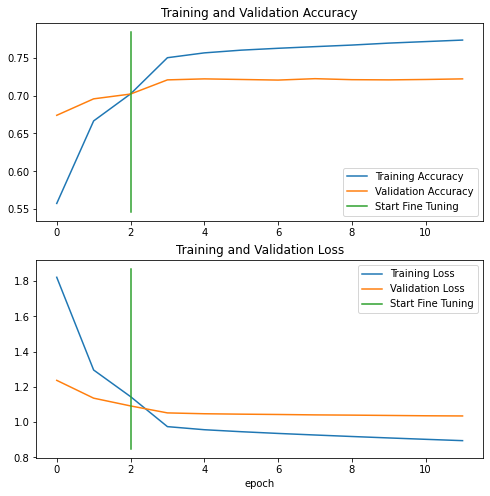

In [47]:
# compare history of feature extraction with fine tuning
compare_historys(history_1_feature_extraction,history_2,initial_epochs=3)

In [48]:
# saving our fine-tuned model

model.save("drive/MyDrive/milestone_food_vision_fine_tune")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## View training results on tensorboard

Upload my training results to tensorboard and use the link to view the model's result

In [49]:
!tensorboard dev --help

usage: tensorboard dev [-h] [--helpfull] [--origin ORIGIN]
                       [--api_endpoint API_ENDPOINT]
                       [--grpc_creds_type {local,ssl,ssl_dev}]
                       [--auth_force_console]
                       {upload,update-metadata,delete,list,export,auth} ...

positional arguments:
  {upload,update-metadata,delete,list,export,auth}
    upload              upload an experiment to TensorBoard.dev
    update-metadata     change the name, description, or other user metadata
                        associated with an experiment.
    delete              permanently delete an experiment
    list                list previously uploaded experiments
    export              download all your experiment data
    auth                log in, log out

optional arguments:
  -h, --help            show this help message and exit
  --helpfull            show full help message and exit
  --origin ORIGIN       Experimental. Origin for TensorBoard.dev service to
        

In [50]:
!tensorboard dev upload \
  --"training_log/efficient_net_ex2" logs \
  --name "Food Vision Experiment 2" \
  --description "added fine-tuning into the model" \
  --one_shot

usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: --training_log/efficient_net_ex2 logs


## Confusion Matrix of the model

In [51]:
# Make predictions with model we will get a tons of probability
pred_prob = model.predict(test_data_processed,verbose=1) 

790/790 [==============================] - 53s 63ms/step


In [52]:
pred_prob[0]

array([2.07869033e-03, 8.75824935e-06, 5.37498545e-06, 1.67314338e-05,
       1.94235516e-04, 1.16489697e-04, 1.05968002e-06, 3.79235134e-05,
       2.49230135e-02, 8.09462159e-04, 3.41417152e-04, 2.69919497e-07,
       6.97511830e-04, 1.29688520e-03, 1.94383401e-03, 8.47226838e-05,
       1.26686217e-02, 4.04692069e-03, 1.13611797e-07, 1.91993913e-05,
       1.80423527e-07, 4.66376916e-03, 7.24165840e-03, 3.18558217e-04,
       1.24349199e-05, 9.54795087e-06, 1.76721267e-04, 1.17745996e-03,
       3.30073308e-05, 4.63608474e-01, 2.49921046e-02, 3.33578209e-04,
       1.95987650e-05, 2.48757921e-08, 1.55218830e-03, 2.17006323e-06,
       4.09138482e-03, 1.10630635e-05, 4.12466136e-07, 7.62610989e-06,
       9.18489377e-07, 8.75966180e-06, 6.63645274e-04, 1.86272712e-06,
       1.48710299e-07, 2.31247112e-01, 1.50943208e-06, 5.06876034e-08,
       2.88943284e-05, 7.07021536e-05, 1.53629355e-06, 1.20211882e-06,
       3.94951821e-05, 3.27090936e-04, 7.41686392e-08, 2.08036709e-05,
      

In [53]:
pred_prob[0][pred_prob[0].argmax()]

0.46360847

In [54]:
# Get the pred classes pf each label
pred_classes = pred_prob.argmax(axis=1)

# How they look like?
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [55]:
# how many predictions are there
len(pred_prob)

25250

In [56]:

# get the labels of test data into a list
y_labels = []
for images,labels in test_data_preprocessed.unbatch():
  y_labels.append(labels.numpy()) 

y_labels[:10] # because we turned the shuffle off in test_data generator

NameError: name 'test_data_preprocessed' is not defined

In [ ]:
# length of labels

len(y_labels)

In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  import matplotlib.pyplot as plt
  import itertools
  import numpy as np
  from sklearn.metrics import confusion_matrix
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## changed(plot x-labels vertically)
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## A function to visualize the model making prediction 

plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

In [ ]:
import random
import matplotlib.pyplot as plt

## the problem is the image size 
def final_model_predict(model=model):
    r_number = random.randint(0,len(test_data))
    random_img = test_data[r_number]
    p_img = test_data_processed[r_number]
    for image,label in random_img:
        print(image.shape)
#         image = tf.image.resize(image,[224,224])
#         p_img preprocessed_img(image)
#         predicted_class = model.predict()
#         if predicted_class == class_names[label.numpy()]:
#             color = 'g'
#         else:
#             color = 'r'
        plt.figure()
        plt.imshow(image)
        plt.title(f"Predicted class:{class_names[label.numpy()]} Label:{class_names[label.numpy()]}")
        plt.axis(False)
        plt.show()
    


In [ ]:
# can rerun this cell mutiple times
final_model_predict()

## Using my own food photo to make prediction

I will choose 3 photo from my phone gallery to make prediction, mostly my favourite food ahahaha

Google drive folder https://drive.google.com/drive/folders/1ahmIUfD7lRoGvu-TYxIPuCjblYnCntE2?usp=share_link

First image : https://drive.google.com/file/d/1sGjwCloy2o1BGbTef_xFZ4hfN2tId6tI/view?usp=share_link sushi

Second image : https://drive.google.com/file/d/1hdziNskCu4IQFcQhQdIT273DaQ2KbpKZ/view?usp=share_link nasi lemak

Third image : https://drive.google.com/file/d/1Ql25g4hvOSgJmHAOZOzwIeE682XIbu-A/view?usp=share_link fries



In [ ]:
img[3]
img[0] = "https://drive.google.com/file/d/1sGjwCloy2o1BGbTef_xFZ4hfN2tId6tI/view?usp=share_link"
img[1] = "https://drive.google.com/file/d/1hdziNskCu4IQFcQhQdIT273DaQ2KbpKZ/view?usp=share_link"
img[2] = "https://drive.google.com/file/d/1Ql25g4hvOSgJmHAOZOzwIeE682XIbu-A/view?usp=share_link"

In [ ]:
! pip install gdown

In [ ]:
import gdown


In [ ]:
for url in img:
    # donwload the image from google drive
    output = 'image.jpeg'
    gdown.download(url, output, quiet=False)
    Load_image = tf.keras.preprocessing.image.load_img(output)
    